<a href="https://colab.research.google.com/github/chiseng/DeepLearning/blob/master/DL3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1

In [0]:
import numpy as np, os, sys
 
import matplotlib.pyplot as plt #patch-wise similarities, droi images
from matplotlib import ticker, cm
 
import torch.nn as nn
import torch.utils.data 
 
import torch.optim

In [0]:
def datagen2d_m(mean2, flip, num):
   
  a1=np.pi*0.0
  mat1=np.array([ [np.cos(a1), np.sin(a1)  ], [ -np.sin(a1), np.cos(a1)] ] ) 
 
  a2=np.pi*0.2
  mat2=np.array([ [np.cos(a2), np.sin(a2)  ], [ -np.sin(a2), np.cos(a2)] ] ) 
 
 
  z1=np.random.normal(size=(num//2,2))
  z1[:,0]=z1[:,0]*3
  x1=np.dot(z1,mat1) 
  z2=np.random.normal(size=(num-num//2,2))
  z2[:,0]=z2[:,0]*3
  x2=np.dot(z2,mat2) + mean2.reshape((1,2))
 
  y1= (np.random.ranf(size=(num//2)) >= flip ).astype(dtype=np.float64)  #np.ones((num//2))+
  y2=  (np.random.ranf(size=(num-num//2)) <= flip ).astype(dtype=np.float64) #np.zeros((num-num//2,2))
 
  # random label noise in y1, y2
 
  x=np.concatenate((x1,x2),axis=0) #existing axis
  y=np.concatenate((y1,y2),axis=0) #existing axis
 
  #x.shape=(numdata,dims) dims=2 here
  #y.shape=(numdata)
 
  print('means',np.mean(y1),np.mean(y2),np.mean(y))
  print(x.shape,y.shape)
 
  # randomly permute
  inds=np.arange(num)
  np.random.shuffle(inds)
  x=x[inds,:]
  y=y[inds]
 
  return x,y # y is 0 or 1 
 
def rndsplit_simple(x,y,numtr):
 
  inds=np.arange(y.size)
  np.random.shuffle(inds)
 
  xtr=x[inds[0:numtr],:]
  ytr=y[inds[0:numtr]]
 
  xv=x[inds[numtr:],:]
  yv=y[inds[numtr:]]
 
  return xtr,ytr,xv,yv
 
 
def gendata():
  mean2=np.asarray([1,3])
  flip=0.1
  num=5000
  x,y=datagen2d_m(mean2, flip, num)
  numtr=3000
  xtr,ytr,xvt,yvt=rndsplit_simple(x,y,numtr)
  xv,yv,xt,yt=rndsplit_simple(xvt,yvt,numtr=1000)
 
  return xtr,ytr,xv,yv,xt,yt
 
 
def visualize_data(xv,yv,w,bias):
   
  possamples=xv[ yv>0, : ]
  negsamples=xv[ yv<=0, : ]
 
  plt.plot(negsamples[:,0],negsamples[:,1],'bx')
  plt.plot(possamples[:,0],possamples[:,1],'rx')
 
  #plot wx+b=0 ... wx= -b, x= a w^O + w/\|w\|^2 * -b
 
 
  def vis1():
    a=np.linspace(-10,10,200)
    worthogonal = np.asarray ( [ -w[1] ,  w[0]   ] ) 
    normedwtimesbias= -bias * w / np.linalg.norm(w)
 
    points=  a*  worthogonal / np.linalg.norm(w) + normedwtimesbias
    points=points.T
    print(points.shape, w.shape)  
 
    plt.plot(points[:,0],points[:,1],'c-', linewidth=5)
 
  def vis2():
    delta=0.05
    x = np.arange(-10.0, 12.0, delta)
    y = np.arange(-10.0, 12.0, delta)
    X, Y = np.meshgrid(x, y)  
 
    U = bias + w[0]*X+ w[1]*Y  
    Z= 1.0/(1.0+np.exp(-U))
 
    CS = plt.contourf(X, Y, Z, levels=8,cmap=cm.viridis) #coolwarm
 
 
  vis2()
  plt.show()
 
 


In [0]:
class logreglayer(nn.Module):
  def __init__(self,dims):
     
    super(logreglayer, self).__init__() #initialize base class
 
    self.bias=torch.nn.Parameter(data=torch.zeros(1),requires_grad=True)
    self.w=torch.nn.Parameter(torch.randn((dims,1),dtype=torch.float64),requires_grad=True)     #TODO
 
  def forward(self,x):
    z = torch.matmul(x,self.w)
    retval = torch.add(self.bias,z)
    return retval

In [0]:
def train_epoch(model,  trainloader,  criterion, device, optimizer, no_grad):
 
     
    model.train()
  
    losses = list()
    for batch_idx, data in enumerate(trainloader):
 
        inputs=data[0].to(device)
        labels=data[1].to(device)
 
        optimizer.zero_grad()
 
        output = model(inputs)
 
        loss = criterion(output.squeeze(1), labels)
        loss.backward()
 
 
        #apply gradient to your parameters in model ... model.w and model.bias ... remember about data and grad :) 
        #TODO
        if no_grad:
            with torch.no_grad():
                model.w -= 0.01*model.w.grad
                model.bias -= 0.01*model.bias.grad
        else:
            optimizer.step()
 
        losses.append(loss.item())
 
    return losses

    

def evaluate(model, dataloader, criterion, device):
 
    model.eval()
 
    gtpos=0
    gtneg=0
    tps=0
    tns=0
    fbeta=1
 
    running_corrects = 0
    with torch.no_grad():
      for ctr, data in enumerate(dataloader):
 
          print ('epoch at',len(dataloader.dataset), ctr)
          inputs = data[0].to(device)        
          outputs = model(inputs)
 
          labels = data[1]
          labels = labels.float()
          cpuout= outputs.to('cpu')
 
          #_, preds = torch.max(cpuout, 1)
          preds = ( cpuout >= 0.5 ).squeeze(1)
          running_corrects += torch.sum(preds == labels.data)
 
      accuracy = running_corrects.double() / len(dataloader.dataset) # this does not work if one uses a datasampler!!!
 
    return accuracy.item() 



def train_modelcv(dataloader_cvtrain, dataloader_cvtest ,  model ,  criterion, optimizer, scheduler, num_epochs, device, no_grad):
 
  best_measure = 0
  best_epoch =-1
 
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
 
    model.train(True)
    losses=train_epoch(model,  dataloader_cvtrain,  criterion,  device , optimizer,no_grad)
    #scheduler.step()
 
    model.train(False)
    measure = evaluate(model, dataloader_cvtest, criterion, device)
    print(' perfmeasure', measure)
 
    if measure > best_measure: 
      bestweights= model.state_dict()
      best_measure = measure
      best_epoch = epoch
      print('current best', measure, ' at epoch ', best_epoch)
 
  return best_epoch, best_measure, bestweights
 

In [0]:
def run(no_grad=False):
 
  #some parameters
  #training batch size
  batch_size=8
  #validation batch size
  valbatch_size=32
  # number of epochs for training
  maxnumepochs=12
  # learning rate
  learningrate=0.01
 
 
   
  #define dataset
  xtr,ytr,xv,yv,xt,yt=gendata()
  xtr = torch.from_numpy(xtr)
  ytr = torch.from_numpy(ytr)
  xv = torch.from_numpy(xv)
  yv = torch.from_numpy(yv)
  xt = torch.from_numpy(xt)
  yt = torch.from_numpy(yt)
  #Tensordataset
  #TODO
  dtr= torch.utils.data.TensorDataset(xtr,ytr) #TensorDataset from tensors from xtr, ytr - our training features and labels
  dv= torch.utils.data.TensorDataset(xv,yv)# TensorDataset from tensors from xv, yv - our validation features and labels
  #define dataloader over dataset
  loadertr=torch.utils.data.DataLoader(dtr,batch_size=batch_size,shuffle=True) # returns an iterator
  loaderval=torch.utils.data.DataLoader(dv,batch_size=valbatch_size,shuffle=False)
 
  #model and loss
  #TODO
  model= logreglayer(xtr.shape[-1])# your logreglayer properly initialized
  z = model.forward(xtr)
  #TODO
  criterion = torch.nn.BCEWithLogitsLoss() # which loss function suits here, given that our model produces 1-dimensional output  and we want to use it for classification?
 
  optimizer=torch.optim.SGD(model.parameters(),lr=learningrate, momentum=0.0, weight_decay=0)
  device=torch.device('cpu')
 
 
  best_epoch, best_perfmeasure, bestweights = train_modelcv(dataloader_cvtrain = loadertr, dataloader_cvtest = loaderval ,  model = model ,  criterion = criterion , optimizer = optimizer, scheduler = None, num_epochs = maxnumepochs , device = device, no_grad = no_grad)
 
 
   
  model.load_state_dict(bestweights)
 
  #TODO
  dte= torch.utils.data.TensorDataset(xt,yt)# TensorDataset from tensors from xte, yte - our test features and labels
  loaderte=torch.utils.data.DataLoader(dte,batch_size=valbatch_size,shuffle=False)
 
  test_accuracy= evaluate(model = model, dataloader = loaderte, criterion = None, device = device)
 
  print('validation accuracy',best_perfmeasure, 'test accuracy',test_accuracy)
 
  visualize_data(xt,yt,model.w.detach(),model.bias.detach())

means 0.8976 0.096 0.4968
(5000, 2) (5000,)
Epoch 0/11
----------
epoch at 1000 0
epoch at 1000 1
epoch at 1000 2
epoch at 1000 3
epoch at 1000 4
epoch at 1000 5
epoch at 1000 6
epoch at 1000 7
epoch at 1000 8
epoch at 1000 9
epoch at 1000 10
epoch at 1000 11
epoch at 1000 12
epoch at 1000 13
epoch at 1000 14
epoch at 1000 15
epoch at 1000 16
epoch at 1000 17
epoch at 1000 18
epoch at 1000 19
epoch at 1000 20
epoch at 1000 21
epoch at 1000 22
epoch at 1000 23
epoch at 1000 24
epoch at 1000 25
epoch at 1000 26
epoch at 1000 27
epoch at 1000 28
epoch at 1000 29
epoch at 1000 30
epoch at 1000 31
 perfmeasure 0.617
current best 0.617  at epoch  0
Epoch 1/11
----------
epoch at 1000 0
epoch at 1000 1
epoch at 1000 2
epoch at 1000 3
epoch at 1000 4
epoch at 1000 5
epoch at 1000 6
epoch at 1000 7
epoch at 1000 8
epoch at 1000 9
epoch at 1000 10
epoch at 1000 11
epoch at 1000 12
epoch at 1000 13
epoch at 1000 14
epoch at 1000 15
epoch at 1000 16
epoch at 1000 17
epoch at 1000 18
epoch at 1000 

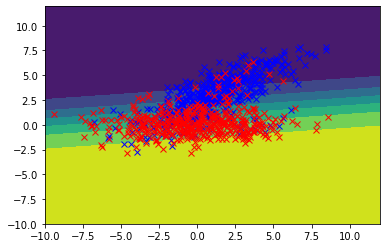

means 0.896 0.0972 0.4966
(5000, 2) (5000,)
Epoch 0/11
----------
epoch at 1000 0
epoch at 1000 1
epoch at 1000 2
epoch at 1000 3
epoch at 1000 4
epoch at 1000 5
epoch at 1000 6
epoch at 1000 7
epoch at 1000 8
epoch at 1000 9
epoch at 1000 10
epoch at 1000 11
epoch at 1000 12
epoch at 1000 13
epoch at 1000 14
epoch at 1000 15
epoch at 1000 16
epoch at 1000 17
epoch at 1000 18
epoch at 1000 19
epoch at 1000 20
epoch at 1000 21
epoch at 1000 22
epoch at 1000 23
epoch at 1000 24
epoch at 1000 25
epoch at 1000 26
epoch at 1000 27
epoch at 1000 28
epoch at 1000 29
epoch at 1000 30
epoch at 1000 31
 perfmeasure 0.518
current best 0.518  at epoch  0
Epoch 1/11
----------
epoch at 1000 0
epoch at 1000 1
epoch at 1000 2
epoch at 1000 3
epoch at 1000 4
epoch at 1000 5
epoch at 1000 6
epoch at 1000 7
epoch at 1000 8
epoch at 1000 9
epoch at 1000 10
epoch at 1000 11
epoch at 1000 12
epoch at 1000 13
epoch at 1000 14
epoch at 1000 15
epoch at 1000 16
epoch at 1000 17
epoch at 1000 18
epoch at 1000 

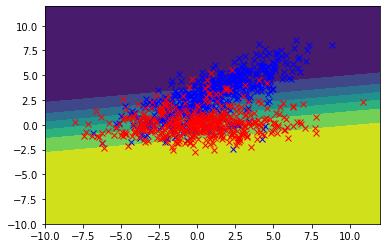

In [0]:
if __name__ == "__main__":
    #run with manual update, insert no_grad=True as parameter as parameter
    run()
    run(no_grad=True)

# Part 2

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import pandas

In [0]:
def data_sampler():
    #change path to download here
    path = "../data"
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.FashionMNIST(path, train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=300, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.FashionMNIST(path, train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=4, shuffle=False)
    val_sample = torch.utils.data.SubsetRandomSampler(range(10000))
    val_loader = torch.utils.data.DataLoader(
        torchvision.datasets.FashionMNIST(path, train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=4, shuffle=False, sampler=val_sample)
    # print(next(iter(val_loader)))
    return train_loader, val_loader, test_loader


In [0]:
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        # images are 28x28 px
        self.fc1 = nn.Linear(28*28, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100,10)
    
    def forward(self,x):
        x = x.view(-1,28*28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


In [0]:
def train_epoch(model, device, criterion, epoch, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        print(output)
        print(target)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # if batch_idx % 10 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader), loss.item()))
    return loss

In [0]:
def train_model(model, device, optimizer,num_epochs, train_loader, val_loader, test_loader, criterion): 
  best_measure = 0
  best_epoch =-1
  metrics = {}
  interm_metrics = {}
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
 
    model.train(True)
    losses = train_epoch(model, device, criterion, epoch, train_loader, optimizer)
    model.train(False)
    acc_val, b_loss_val   = validate(model, device, val_loader, criterion)
    measure, b_loss_test = validate(model, device, test_loader, criterion)
    acc_train, b_loss_train = validate(model, device, train_loader, criterion)
    interm_metrics = {"acc_train":acc_train,"acc_val":acc_val,"acc_test":measure,"val_loss":b_loss_val,"test_loss":b_loss_test,"train_loss":b_loss_train}
    metrics[epoch] = interm_metrics
    print(' perfmeasure', measure)
 
    if measure > best_measure:
      bestweights= model.state_dict()
      best_measure = measure
      best_epoch = epoch
      print('current best', measure, ' at epoch ', best_epoch)
    break
#   print(metrics)
 
  return best_epoch, best_measure, bestweights, metrics


In [0]:
def validate(model, device, val_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    cumul_loss = {}
    with torch.no_grad():
        for i_batch, (data,target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            cumul_loss[i_batch] = loss.item()
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            total += data.size(0)
            correct += pred.eq(target.view_as(pred)).sum().item()
    return correct/total, np.round(np.array(list(cumul_loss.values())).mean(),3)

In [0]:
def run():
    trainloader, valloader, testloader = data_sampler()
    device=torch.device('cpu')
    nn_model = model().to(device)
    optimizer = optim.SGD(nn_model.parameters(), lr=0.01)
    num_epochs = 8
    criterion = nn.CrossEntropyLoss()
    _,best_measure, bestweights, metrics = train_model(nn_model,device, optimizer, num_epochs,trainloader, valloader, testloader, criterion)
    # print(metrics)
    nn_model.load_state_dict(bestweights)
    test_accuracy, _ = validate(nn_model, device, testloader,criterion)
    print('validation accuracy',best_measure, 'test accuracy',test_accuracy)
    listed = list(metrics.values())
    df = pandas.DataFrame(data = listed)
    df.plot(y=['acc_train','acc_val','acc_test'])
    df.plot(y=['train_loss','val_loss','test_loss'])

In [0]:
if __name__ == "__main__":
    run()

Epoch 0/7
----------
tensor([[-0.2759,  0.0383, -0.0966,  ...,  0.0738,  0.1358, -0.2063],
        [-0.2433,  0.0706,  0.0633,  ...,  0.0382, -0.0747,  0.0694],
        [-0.2446, -0.0206,  0.0472,  ...,  0.0095,  0.0687, -0.0239],
        ...,
        [-0.1345,  0.0316,  0.0032,  ..., -0.0314,  0.0805,  0.1030],
        [-0.3273,  0.0156,  0.1589,  ...,  0.0767, -0.0583,  0.0328],
        [-0.2352,  0.1358, -0.0457,  ...,  0.1782,  0.0434, -0.0203]],
       grad_fn=<AddmmBackward>)
tensor([9, 6, 8, 5, 4, 4, 9, 6, 2, 4, 4, 1, 0, 9, 1, 6, 5, 9, 3, 8, 9, 0, 3, 3,
        3, 0, 4, 2, 6, 4, 6, 5, 6, 9, 1, 3, 6, 6, 8, 2, 7, 5, 9, 2, 3, 7, 5, 3,
        6, 0, 0, 6, 6, 3, 3, 8, 9, 8, 9, 0, 5, 0, 9, 0, 2, 1, 1, 2, 2, 9, 7, 0,
        6, 5, 4, 9, 1, 5, 3, 2, 4, 6, 5, 1, 7, 2, 7, 8, 7, 5, 9, 4, 3, 2, 8, 1,
        9, 3, 3, 2, 8, 9, 4, 4, 2, 1, 4, 2, 6, 8, 1, 4, 1, 9, 1, 1, 2, 4, 1, 5,
        8, 6, 2, 5, 8, 4, 5, 1, 8, 4, 6, 5, 5, 7, 5, 7, 6, 3, 9, 6, 5, 1, 4, 5,
        3, 8, 7, 2, 0, 3, 9, 8, 8

KeyboardInterrupt: ignored

# Part 3

Selecting the model based on all epochs of the test dataset will cause the model to be biased towards the test values which may not give a good fitting to other test sets. The validation set is a part of the training set that ensures the model is training well on the training data and thus we should be using models with good parameters after validating on the validation set.